<a href="https://colab.research.google.com/github/Diana-codes/Advanced-Linear-algebra/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Sentiment Analysis: SVM vs GRU on Amazon Reviews
# This notebook loads preprocessed data and trains/compares models
# Requires: processed_data/ folder with TF-IDF features, sequences, embeddings, and labels

import os
import json
import pickle
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

# Scikit-learn for SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow/Keras for GRU
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: []


In [19]:
!mkdir -p processed_data
!mv *.npy processed_data/
!mv *.json processed_data/
!mv *.pkl processed_data/
!mv *.csv processed_data/
!mv *.npz processed_data/

mv: cannot stat '*.npy': No such file or directory
mv: cannot stat '*.json': No such file or directory
mv: cannot stat '*.pkl': No such file or directory
mv: cannot stat '*.csv': No such file or directory


In [20]:
data = np.load("processed_data/X_train_tfidf.npz", allow_pickle=True)
print("Keys inside npz:", data.files)

Keys inside npz: ['indices', 'indptr', 'format', 'shape', 'data', 'X_val_tfidf.npz']


In [22]:
from scipy.sparse import csr_matrix
def load_sparse_matrix(path):
    data = np.load(path, allow_pickle=True)
    return csr_matrix((data["data"], data["indices"], data["indptr"]), shape=data["shape"])

print("\nLoading TF-IDF features...")
X_train_tfidf = load_sparse_matrix("processed_data/X_train_tfidf.npz")
X_val_tfidf   = load_sparse_matrix("processed_data/X_val_tfidf.npz")
X_test_tfidf  = load_sparse_matrix("processed_data/X_test_tfidf.npz")


Loading TF-IDF features...


In [23]:
# ============================================================================
# STAGE 1: LOAD PREPROCESSED DATA
# ============================================================================

print("\n" + "="*80)
print("STAGE 1: LOADING PREPROCESSED DATA")
print("="*80)

# Load TF-IDF features (for SVM)
print("\nLoading TF-IDF features...")
X_train_tfidf = sparse.load_npz("processed_data/X_train_tfidf.npz")
X_val_tfidf = sparse.load_npz("processed_data/X_val_tfidf.npz")
X_test_tfidf = sparse.load_npz("processed_data/X_test_tfidf.npz")


# Load sequences (for GRU)
print("Loading padded sequences...")
X_train_seq = np.load("processed_data/X_train_seq.npy")
X_val_seq = np.load("processed_data/X_val_seq.npy")
X_test_seq = np.load("processed_data/X_test_seq.npy")

# Load labels
print("Loading labels...")
y_train = np.load("processed_data/y_train.npy")
y_val = np.load("processed_data/y_val.npy")
y_test = np.load("processed_data/y_test.npy")

# Load embedding matrix
print("Loading embedding matrix...")
embedding_matrix = np.load("processed_data/embedding_matrix_glove100.npy")

# Load word index
with open("processed_data/word_index.json", "r") as f:
    word_index = json.load(f)

print("\n✓ Data loaded successfully!")
print(f"  - TF-IDF shapes: Train {X_train_tfidf.shape}, Val {X_val_tfidf.shape}, Test {X_test_tfidf.shape}")
print(f"  - Sequence shapes: Train {X_train_seq.shape}, Val {X_val_seq.shape}, Test {X_test_seq.shape}")
print(f"  - Label shapes: Train {y_train.shape}, Val {y_val.shape}, Test {y_test.shape}")
print(f"  - Embedding matrix: {embedding_matrix.shape}")
print(f"  - Vocabulary size: {len(word_index)}")

# Class distribution
print(f"\nClass distribution:")
print(f"  Train - Positive: {np.sum(y_train)}/{len(y_train)} ({100*np.mean(y_train):.1f}%)")
print(f"  Val   - Positive: {np.sum(y_val)}/{len(y_val)} ({100*np.mean(y_val):.1f}%)")
print(f"  Test  - Positive: {np.sum(y_test)}/{len(y_test)} ({100*np.mean(y_test):.1f}%)")


STAGE 1: LOADING PREPROCESSED DATA

Loading TF-IDF features...
Loading padded sequences...
Loading labels...
Loading embedding matrix...

✓ Data loaded successfully!
  - TF-IDF shapes: Train (49842, 30000), Val (7121, 30000), Test (14241, 30000)
  - Sequence shapes: Train (49842, 200), Val (7121, 200), Test (14241, 200)
  - Label shapes: Train (49842,), Val (7121,), Test (14241,)
  - Embedding matrix: (20530, 100)
  - Vocabulary size: 20529

Class distribution:
  Train - Positive: 42110/49842 (84.5%)
  Val   - Positive: 6016/7121 (84.5%)
  Test  - Positive: 12032/14241 (84.5%)


In [24]:
# ============================================================================
# STAGE 2: TRADITIONAL ML - SUPPORT VECTOR MACHINE (SVM)
# ============================================================================

print("\n" + "="*80)
print("STAGE 2: TRADITIONAL ML - SUPPORT VECTOR MACHINE (SVM)")
print("="*80)

print("\n📊 Why SVM for Text Classification?")
print("  ✓ Effective in high-dimensional spaces (TF-IDF features)")
print("  ✓ Memory efficient (uses support vectors)")
print("  ✓ Works well with sparse data")
print("  ✓ Good generalization with proper regularization")

# Store experiment results
svm_experiments = []


STAGE 2: TRADITIONAL ML - SUPPORT VECTOR MACHINE (SVM)

📊 Why SVM for Text Classification?
  ✓ Effective in high-dimensional spaces (TF-IDF features)
  ✓ Memory efficient (uses support vectors)
  ✓ Works well with sparse data
  ✓ Good generalization with proper regularization


In [25]:
# ============================================================================
# Experiment 1: SVM with C=0.1 (Strong regularization)
# ============================================================================
print("\n" + "-"*80)
print("Experiment 1: SVM with C=0.1 (Strong Regularization)")
print("-"*80)

svm_model_1 = LinearSVC(C=0.1, max_iter=1000, random_state=42, dual=False)
print("Training SVM (C=0.1)...")
svm_model_1.fit(X_train_tfidf, y_train)

# Evaluate
train_pred_1 = svm_model_1.predict(X_train_tfidf)
val_pred_1 = svm_model_1.predict(X_val_tfidf)
test_pred_1 = svm_model_1.predict(X_test_tfidf)

train_acc_1 = accuracy_score(y_train, train_pred_1)
val_acc_1 = accuracy_score(y_val, val_pred_1)
test_acc_1 = accuracy_score(y_test, test_pred_1)

print(f"✓ Train Accuracy: {train_acc_1:.4f}")
print(f"✓ Val Accuracy:   {val_acc_1:.4f}")
print(f"✓ Test Accuracy:  {test_acc_1:.4f}")

svm_experiments.append({
    "Model": "SVM",
    "C": 0.1,
    "Max Features": 30000,
    "N-grams": "(1,2)",
    "Train Acc": train_acc_1,
    "Val Acc": val_acc_1,
    "Test Acc": test_acc_1
})


--------------------------------------------------------------------------------
Experiment 1: SVM with C=0.1 (Strong Regularization)
--------------------------------------------------------------------------------
Training SVM (C=0.1)...
✓ Train Accuracy: 0.9407
✓ Val Accuracy:   0.9221
✓ Test Accuracy:  0.9225


In [26]:
# ============================================================================
# Experiment 2: SVM with C=1.0 (Moderate regularization)
# ============================================================================
print("\n" + "-"*80)
print("Experiment 2: SVM with C=1.0 (Moderate Regularization)")
print("-"*80)

svm_model_2 = LinearSVC(C=1.0, max_iter=1000, random_state=42, dual=False)
print("Training SVM (C=1.0)...")
svm_model_2.fit(X_train_tfidf, y_train)

train_pred_2 = svm_model_2.predict(X_train_tfidf)
val_pred_2 = svm_model_2.predict(X_val_tfidf)
test_pred_2 = svm_model_2.predict(X_test_tfidf)

train_acc_2 = accuracy_score(y_train, train_pred_2)
val_acc_2 = accuracy_score(y_val, val_pred_2)
test_acc_2 = accuracy_score(y_test, test_pred_2)

print(f"✓ Train Accuracy: {train_acc_2:.4f}")
print(f"✓ Val Accuracy:   {val_acc_2:.4f}")
print(f"✓ Test Accuracy:  {test_acc_2:.4f}")

svm_experiments.append({
    "Model": "SVM",
    "C": 1.0,
    "Max Features": 30000,
    "N-grams": "(1,2)",
    "Train Acc": train_acc_2,
    "Val Acc": val_acc_2,
    "Test Acc": test_acc_2
})


--------------------------------------------------------------------------------
Experiment 2: SVM with C=1.0 (Moderate Regularization)
--------------------------------------------------------------------------------
Training SVM (C=1.0)...
✓ Train Accuracy: 0.9887
✓ Val Accuracy:   0.9330
✓ Test Accuracy:  0.9348


In [27]:
# ============================================================================
# Experiment 3: SVM with C=10.0 (Weak regularization)
# ============================================================================
print("\n" + "-"*80)
print("Experiment 3: SVM with C=10.0 (Weak Regularization)")
print("-"*80)

svm_model_3 = LinearSVC(C=10.0, max_iter=1000, random_state=42, dual=False)
print("Training SVM (C=10.0)...")
svm_model_3.fit(X_train_tfidf, y_train)

train_pred_3 = svm_model_3.predict(X_train_tfidf)
val_pred_3 = svm_model_3.predict(X_val_tfidf)
test_pred_3 = svm_model_3.predict(X_test_tfidf)

train_acc_3 = accuracy_score(y_train, train_pred_3)
val_acc_3 = accuracy_score(y_val, val_pred_3)
test_acc_3 = accuracy_score(y_test, test_pred_3)

print(f"✓ Train Accuracy: {train_acc_3:.4f}")
print(f"✓ Val Accuracy:   {val_acc_3:.4f}")
print(f"✓ Test Accuracy:  {test_acc_3:.4f}")

svm_experiments.append({
    "Model": "SVM",
    "C": 10.0,
    "Max Features": 30000,
    "N-grams": "(1,2)",
    "Train Acc": train_acc_3,
    "Val Acc": val_acc_3,
    "Test Acc": test_acc_3
})

# Select best SVM model based on validation accuracy
best_svm_idx = np.argmax([exp["Val Acc"] for exp in svm_experiments])
best_svm_model = [svm_model_1, svm_model_2, svm_model_3][best_svm_idx]
best_svm_exp = svm_experiments[best_svm_idx]

print(f"\n🏆 Best SVM Model: C={best_svm_exp['C']}")
print(f"   Val Accuracy: {best_svm_exp['Val Acc']:.4f}")
print(f"   Test Accuracy: {best_svm_exp['Test Acc']:.4f}")


--------------------------------------------------------------------------------
Experiment 3: SVM with C=10.0 (Weak Regularization)
--------------------------------------------------------------------------------
Training SVM (C=10.0)...
✓ Train Accuracy: 1.0000
✓ Val Accuracy:   0.9229
✓ Test Accuracy:  0.9260

🏆 Best SVM Model: C=1.0
   Val Accuracy: 0.9330
   Test Accuracy: 0.9348


In [28]:
# ============================================================================
# STAGE 3: DEEP LEARNING - GATED RECURRENT UNIT (GRU)
# ============================================================================

print("\n" + "="*80)
print("STAGE 3: DEEP LEARNING - GATED RECURRENT UNIT (GRU)")
print("="*80)

print("\n📊 Why GRU for Text Classification?")
print("  ✓ Captures sequential dependencies in text")
print("  ✓ Simpler than LSTM (fewer parameters)")
print("  ✓ Faster training than LSTM")
print("  ✓ Effective at learning long-range dependencies")
print("  ✓ Less prone to vanishing gradients than vanilla RNN")

# Store GRU experiment results
gru_experiments = []

# Get embedding dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_length = X_train_seq.shape[1]

print(f"\nGRU Configuration:")
print(f"  - Vocabulary size: {vocab_size}")
print(f"  - Embedding dimension: {embedding_dim}")
print(f"  - Sequence length: {max_length}")


STAGE 3: DEEP LEARNING - GATED RECURRENT UNIT (GRU)

📊 Why GRU for Text Classification?
  ✓ Captures sequential dependencies in text
  ✓ Simpler than LSTM (fewer parameters)
  ✓ Faster training than LSTM
  ✓ Effective at learning long-range dependencies
  ✓ Less prone to vanishing gradients than vanilla RNN

GRU Configuration:
  - Vocabulary size: 20530
  - Embedding dimension: 100
  - Sequence length: 200


In [29]:
# ============================================================================
# Experiment 4: GRU with 64 units, frozen embeddings
# ============================================================================
print("\n" + "-"*80)
print("Experiment 4: GRU (64 units, Frozen GloVe Embeddings)")
print("-"*80)

model_gru_1 = models.Sequential([
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,  # Frozen embeddings
        name="frozen_glove_embedding"
    ),
    layers.GRU(64, return_sequences=False, name="gru_64"),
    layers.Dropout(0.3, name="dropout_1"),
    layers.Dense(32, activation='relu', name="dense_32"),
    layers.Dropout(0.2, name="dropout_2"),
    layers.Dense(1, activation='sigmoid', name="output")
], name="GRU_64_Frozen")

model_gru_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model_gru_1.summary()

# Callbacks
early_stop_1 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train
print("\nTraining GRU (64 units, frozen embeddings)...")
history_1 = model_gru_1.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop_1],
    verbose=1
)

# Evaluate
train_loss_1, train_acc_1 = model_gru_1.evaluate(X_train_seq, y_train, verbose=0)
val_loss_1, val_acc_1 = model_gru_1.evaluate(X_val_seq, y_val, verbose=0)
test_loss_1, test_acc_1 = model_gru_1.evaluate(X_test_seq, y_test, verbose=0)

print(f"\n✓ Train Accuracy: {train_acc_1:.4f}")
print(f"✓ Val Accuracy:   {val_acc_1:.4f}")
print(f"✓ Test Accuracy:  {test_acc_1:.4f}")

gru_experiments.append({
    "Model": "GRU",
    "Units": 64,
    "Embeddings": "Frozen GloVe",
    "Learning Rate": 0.001,
    "Batch Size": 128,
    "Train Acc": train_acc_1,
    "Val Acc": val_acc_1,
    "Test Acc": test_acc_1
})


--------------------------------------------------------------------------------
Experiment 4: GRU (64 units, Frozen GloVe Embeddings)
--------------------------------------------------------------------------------

Model Architecture:


Model: "GRU_64_Frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frozen_glove_embedding          │ ?                      │     2,053,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_64 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,053,000 (7.83 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,053,000 (7.83 MB)


Training GRU (64 units, frozen embeddings)...
Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 144s 360ms/step - accuracy: 0.8323 - loss: 0.4804 - val_accuracy: 0.8448 - val_loss: 0.4315
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 139s 354ms/step - accuracy: 0.8440 - loss: 0.4377 - val_accuracy: 0.8451 - val_loss: 0.4311
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 136s 348ms/step - accuracy: 0.8444 - loss: 0.4366 - val_accuracy: 0.8451 - val_loss: 0.4310
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 140s 359ms/step - accuracy: 0.8445 - loss: 0.4357 - val_accuracy: 0.8452 - val_loss: 0.4308
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 140s 355ms/step - accuracy: 0.8446 - loss: 0.4355 - val_accuracy: 0.8454 - val_loss: 0.4307
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 143s 357ms/step - accuracy: 0.8446 - loss: 0.4348 - val_accuracy: 0.8454 - val_loss: 0.4306
Epoch 7/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 142s 364ms/step - accuracy: 0.8446 - loss: 0.4344 - val_accuracy: 0.8455 - val_loss: 0.4306
Epoch 8/15
390/390 ━━━━━━━━━━

In [30]:
# ============================================================================
# Experiment 5: GRU with 128 units, frozen embeddings
# ============================================================================
print("\n" + "-"*80)
print("Experiment 5: GRU (128 units, Frozen GloVe Embeddings)")
print("-"*80)

model_gru_2 = models.Sequential([
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,
        name="frozen_glove_embedding"
    ),
    layers.GRU(128, return_sequences=False, name="gru_128"),
    layers.Dropout(0.3, name="dropout_1"),
    layers.Dense(64, activation='relu', name="dense_64"),
    layers.Dropout(0.2, name="dropout_2"),
    layers.Dense(1, activation='sigmoid', name="output")
], name="GRU_128_Frozen")

model_gru_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model_gru_2.summary()

early_stop_2 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining GRU (128 units, frozen embeddings)...")
history_2 = model_gru_2.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop_2],
    verbose=1
)

train_loss_2, train_acc_2 = model_gru_2.evaluate(X_train_seq, y_train, verbose=0)
val_loss_2, val_acc_2 = model_gru_2.evaluate(X_val_seq, y_val, verbose=0)
test_loss_2, test_acc_2 = model_gru_2.evaluate(X_test_seq, y_test, verbose=0)

print(f"\n✓ Train Accuracy: {train_acc_2:.4f}")
print(f"✓ Val Accuracy:   {val_acc_2:.4f}")
print(f"✓ Test Accuracy:  {test_acc_2:.4f}")

gru_experiments.append({
    "Model": "GRU",
    "Units": 128,
    "Embeddings": "Frozen GloVe",
    "Learning Rate": 0.001,
    "Batch Size": 128,
    "Train Acc": train_acc_2,
    "Val Acc": val_acc_2,
    "Test Acc": test_acc_2
})


--------------------------------------------------------------------------------
Experiment 5: GRU (128 units, Frozen GloVe Embeddings)
--------------------------------------------------------------------------------

Model Architecture:


Model: "GRU_128_Frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frozen_glove_embedding          │ ?                      │     2,053,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_128 (GRU)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,053,000 (7.83 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,053,000 (7.83 MB)


Training GRU (128 units, frozen embeddings)...
Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 249s 631ms/step - accuracy: 0.8320 - loss: 0.4654 - val_accuracy: 0.8448 - val_loss: 0.4319
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 253s 607ms/step - accuracy: 0.8441 - loss: 0.4351 - val_accuracy: 0.8451 - val_loss: 0.4312
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 243s 624ms/step - accuracy: 0.8445 - loss: 0.4342 - val_accuracy: 0.8451 - val_loss: 0.4308
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 237s 605ms/step - accuracy: 0.8446 - loss: 0.4336 - val_accuracy: 0.8451 - val_loss: 0.4307
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 234s 599ms/step - accuracy: 0.8447 - loss: 0.4337 - val_accuracy: 0.8454 - val_loss: 0.4306
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 234s 599ms/step - accuracy: 0.8448 - loss: 0.4337 - val_accuracy: 0.8454 - val_loss: 0.4305
Epoch 7/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 235s 602ms/step - accuracy: 0.8448 - loss: 0.4328 - val_accuracy: 0.8455 - val_loss: 0.4304
Epoch 8/15
390/390 ━━━━━━━━━

In [31]:
# ============================================================================
# Experiment 6: GRU with 128 units, fine-tuned embeddings
# ============================================================================
print("\n" + "-"*80)
print("Experiment 6: GRU (128 units, Fine-tuned GloVe Embeddings)")
print("-"*80)

model_gru_3 = models.Sequential([
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,  # Fine-tune embeddings
        name="finetuned_glove_embedding"
    ),
    layers.GRU(128, return_sequences=False, name="gru_128"),
    layers.Dropout(0.3, name="dropout_1"),
    layers.Dense(64, activation='relu', name="dense_64"),
    layers.Dropout(0.2, name="dropout_2"),
    layers.Dense(1, activation='sigmoid', name="output")
], name="GRU_128_Finetuned")

model_gru_3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model_gru_3.summary()

early_stop_3 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining GRU (128 units, fine-tuned embeddings)...")
history_3 = model_gru_3.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop_3],
    verbose=1
)

train_loss_3, train_acc_3 = model_gru_3.evaluate(X_train_seq, y_train, verbose=0)
val_loss_3, val_acc_3 = model_gru_3.evaluate(X_val_seq, y_val, verbose=0)
test_loss_3, test_acc_3 = model_gru_3.evaluate(X_test_seq, y_test, verbose=0)

print(f"\n✓ Train Accuracy: {train_acc_3:.4f}")
print(f"✓ Val Accuracy:   {val_acc_3:.4f}")
print(f"✓ Test Accuracy:  {test_acc_3:.4f}")

gru_experiments.append({
    "Model": "GRU",
    "Units": 128,
    "Embeddings": "Fine-tuned GloVe",
    "Learning Rate": 0.0005,
    "Batch Size": 128,
    "Train Acc": train_acc_3,
    "Val Acc": val_acc_3,
    "Test Acc": test_acc_3
})

# Select best GRU model
best_gru_idx = np.argmax([exp["Val Acc"] for exp in gru_experiments])
best_gru_model = [model_gru_1, model_gru_2, model_gru_3][best_gru_idx]
best_gru_exp = gru_experiments[best_gru_idx]

print(f"\n🏆 Best GRU Model: {best_gru_exp['Units']} units, {best_gru_exp['Embeddings']}")
print(f"   Val Accuracy: {best_gru_exp['Val Acc']:.4f}")
print(f"   Test Accuracy: {best_gru_exp['Test Acc']:.4f}")


--------------------------------------------------------------------------------
Experiment 6: GRU (128 units, Fine-tuned GloVe Embeddings)
--------------------------------------------------------------------------------

Model Architecture:


Model: "GRU_128_Finetuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ finetuned_glove_embedding       │ ?                      │     2,053,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_128 (GRU)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,053,000 (7.83 MB)

 Trainable params: 2,053,000 (7.83 MB)

 Non-trainable params: 0 (0.00 B)


Training GRU (128 units, fine-tuned embeddings)...
Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 291s 735ms/step - accuracy: 0.8319 - loss: 0.4638 - val_accuracy: 0.8451 - val_loss: 0.4317
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 294s 755ms/step - accuracy: 0.8445 - loss: 0.4362 - val_accuracy: 0.8451 - val_loss: 0.4310
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 291s 746ms/step - accuracy: 0.8446 - loss: 0.4357 - val_accuracy: 0.8455 - val_loss: 0.4304
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 327s 759ms/step - accuracy: 0.8453 - loss: 0.4336 - val_accuracy: 0.8454 - val_loss: 0.4305
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 313s 736ms/step - accuracy: 0.8457 - loss: 0.4324 - val_accuracy: 0.8450 - val_loss: 0.4307
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 289s 742ms/step - accuracy: 0.8457 - loss: 0.4312 - val_accuracy: 0.8451 - val_loss: 0.4308
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

✓ Train Accuracy: 0.8463
✓ Val Accuracy:   0.8455
✓ Test Accuracy:  0.84


STAGE 4: EXPERIMENT COMPARISON & ANALYSIS

📊 EXPERIMENT RESULTS TABLE
Model    C  Max Features N-grams  Train Acc  Val Acc  Test Acc  Units       Embeddings  Learning Rate  Batch Size
  SVM  0.1       30000.0   (1,2)   0.940652 0.922062  0.922548    NaN              NaN            NaN         NaN
  SVM  1.0       30000.0   (1,2)   0.988684 0.933015  0.934836    NaN              NaN            NaN         NaN
  SVM 10.0       30000.0   (1,2)   0.999980 0.922904  0.925988    NaN              NaN            NaN         NaN
  GRU  NaN           NaN     NaN   0.846013 0.845246  0.845165   64.0     Frozen GloVe         0.0010       128.0
  GRU  NaN           NaN     NaN   0.846054 0.845527  0.845095  128.0     Frozen GloVe         0.0010       128.0
  GRU  NaN           NaN     NaN   0.846274 0.845527  0.845376  128.0 Fine-tuned GloVe         0.0005       128.0

✓ Saved experiment comparison plot: experiment_comparison.png


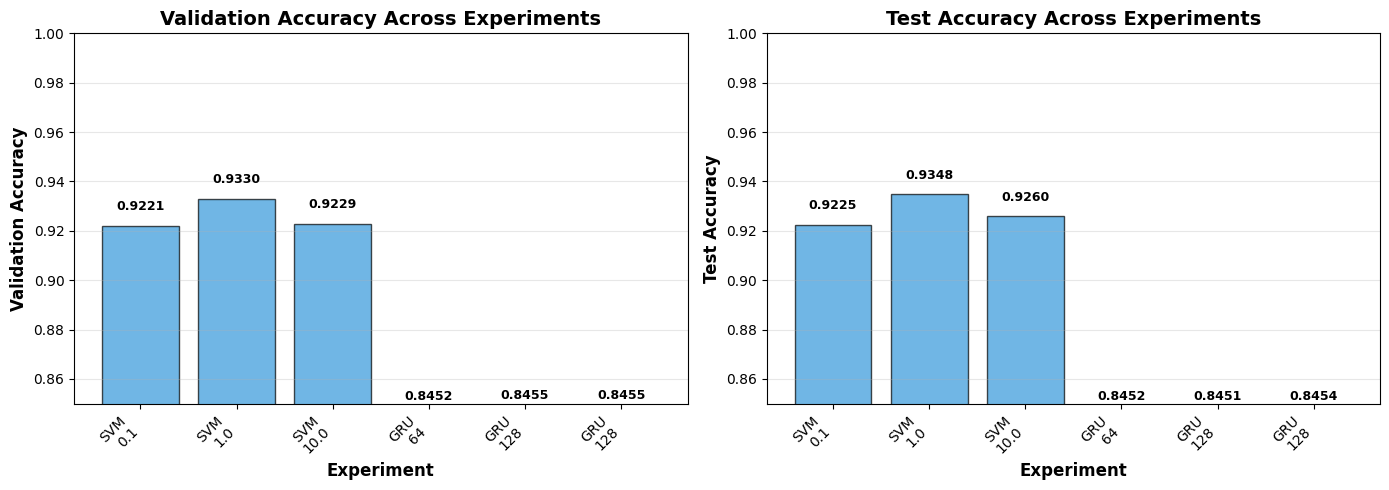

In [32]:
# ============================================================================
# STAGE 4: EXPERIMENT COMPARISON & ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STAGE 4: EXPERIMENT COMPARISON & ANALYSIS")
print("="*80)

# Combine all experiments
all_experiments = svm_experiments + gru_experiments
df_experiments = pd.DataFrame(all_experiments)

print("\n📊 EXPERIMENT RESULTS TABLE")
print("="*80)
print(df_experiments.to_string(index=False))
print("="*80)

# Visualize experiment comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Validation Accuracy Comparison
ax1 = axes[0]
exp_names = [f"{exp['Model']}\n{exp.get('C', exp.get('Units', ''))}" for exp in all_experiments]
val_accs = [exp['Val Acc'] for exp in all_experiments]
colors = ['#3498db' if exp['Model'] == 'SVM' else '#e74c3c' for exp in all_experiments]

bars = ax1.bar(range(len(exp_names)), val_accs, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Validation Accuracy Across Experiments', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(exp_names)))
ax1.set_xticklabels(exp_names, rotation=45, ha='right')
ax1.set_ylim([0.85, 1.0])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, val_accs)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Test Accuracy Comparison
ax2 = axes[1]
test_accs = [exp['Test Acc'] for exp in all_experiments]

bars2 = ax2.bar(range(len(exp_names)), test_accs, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax2.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Test Accuracy Across Experiments', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(exp_names)))
ax2.set_xticklabels(exp_names, rotation=45, ha='right')
ax2.set_ylim([0.85, 1.0])
ax2.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars2, test_accs)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved experiment comparison plot: experiment_comparison.png")
plt.show()


STAGE 5: DETAILED EVALUATION OF BEST MODELS

--------------------------------------------------------------------------------
BEST SVM MODEL (C=1.0)
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8431    0.7125    0.7723      2209
    Positive     0.9487    0.9756    0.9620     12032

    accuracy                         0.9348     14241
   macro avg     0.8959    0.8441    0.8672     14241
weighted avg     0.9323    0.9348    0.9326     14241


✓ Saved SVM confusion matrix: confusion_matrix_svm.png


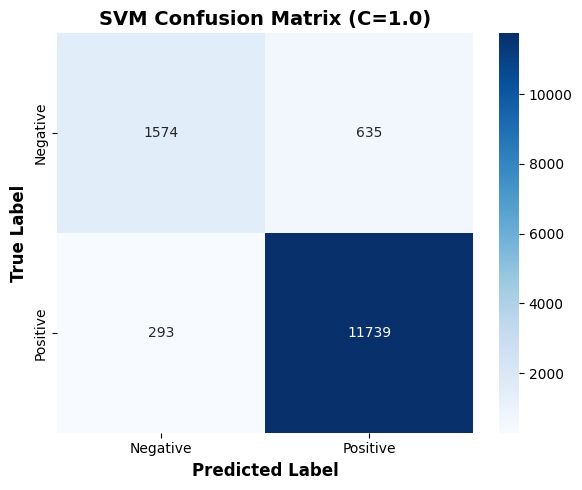


--------------------------------------------------------------------------------
BEST GRU MODEL (128 units, Frozen GloVe)
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6000    0.0041    0.0081      2209
    Positive     0.8454    0.9995    0.9160     12032

    accuracy                         0.8451     14241
   macro avg     0.7227    0.5018    0.4620     14241
weighted avg     0.8073    0.8451    0.7752     14241


✓ Saved GRU confusion matrix: confusion_matrix_gru.png


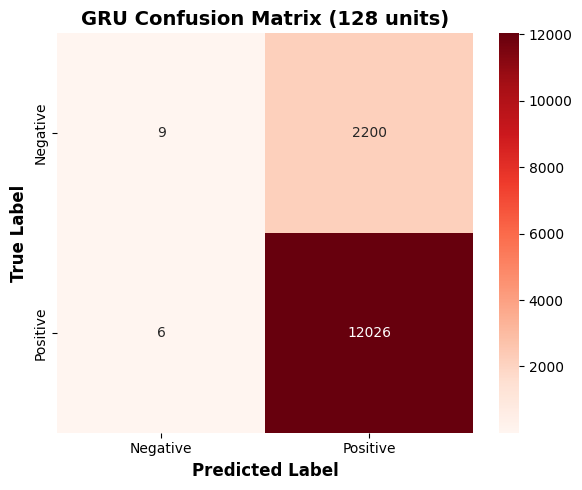

In [33]:
# ============================================================================
# STAGE 5: DETAILED EVALUATION OF BEST MODELS
# ============================================================================

print("\n" + "="*80)
print("STAGE 5: DETAILED EVALUATION OF BEST MODELS")
print("="*80)

# Best SVM Evaluation
print("\n" + "-"*80)
print(f"BEST SVM MODEL (C={best_svm_exp['C']})")
print("-"*80)

y_pred_svm = best_svm_model.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Negative', 'Positive'], digits=4))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'SVM Confusion Matrix (C={best_svm_exp["C"]})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_svm.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved SVM confusion matrix: confusion_matrix_svm.png")
plt.show()

# Best GRU Evaluation
print("\n" + "-"*80)
print(f"BEST GRU MODEL ({best_gru_exp['Units']} units, {best_gru_exp['Embeddings']})")
print("-"*80)

y_pred_gru_probs = best_gru_model.predict(X_test_seq, verbose=0)
y_pred_gru = (y_pred_gru_probs > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gru, target_names=['Negative', 'Positive'], digits=4))

# Confusion Matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Reds', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'GRU Confusion Matrix ({best_gru_exp["Units"]} units)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_gru.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved GRU confusion matrix: confusion_matrix_gru.png")
plt.show()


STAGE 6: TRAINING HISTORY VISUALIZATION

✓ Saved GRU training history: training_history_gru.png


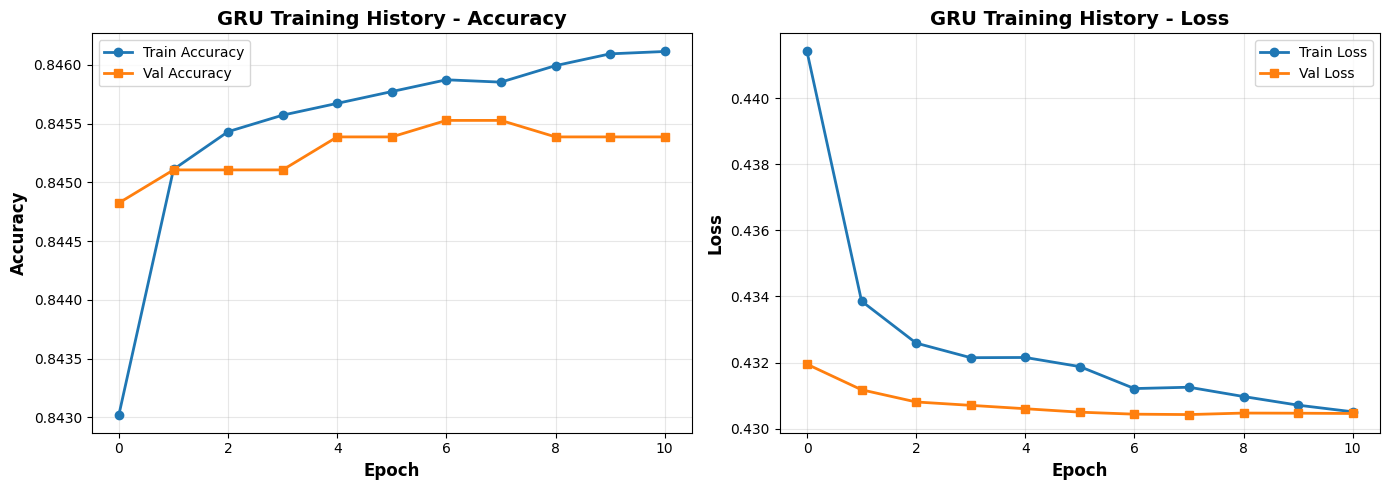

In [34]:
# ============================================================================
# STAGE 6: TRAINING HISTORY VISUALIZATION (GRU)
# ============================================================================

print("\n" + "="*80)
print("STAGE 6: TRAINING HISTORY VISUALIZATION")
print("="*80)

# Plot training history for best GRU model
best_history = [history_1, history_2, history_3][best_gru_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1 = axes[0]
ax1.plot(best_history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
ax1.plot(best_history.history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('GRU Training History - Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Loss plot
ax2 = axes[1]
ax2.plot(best_history.history['loss'], label='Train Loss', marker='o', linewidth=2)
ax2.plot(best_history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('GRU Training History - Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_gru.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved GRU training history: training_history_gru.png")
plt.show()

In [35]:
# ============================================================================
# STAGE 7: DISCUSSION & CONCLUSIONS
# ============================================================================

print("\n" + "="*80)
print("STAGE 7: DISCUSSION & CONCLUSIONS")
print("="*80)

print("\n📊 KEY FINDINGS:")
print("-" * 80)

# Compare best models
best_overall_idx = np.argmax([exp['Test Acc'] for exp in all_experiments])
best_overall = all_experiments[best_overall_idx]

print(f"\n🏆 BEST OVERALL MODEL: {best_overall['Model']}")
if best_overall['Model'] == 'SVM':
    print(f"   Configuration: C={best_overall['C']}, {best_overall['Max Features']} features")
else:
    print(f"   Configuration: {best_overall['Units']} units, {best_overall['Embeddings']}")
print(f"   Test Accuracy: {best_overall['Test Acc']:.4f}")

print("\n📈 PERFORMANCE ANALYSIS:")
print("-" * 80)

# SVM analysis
avg_svm_test = np.mean([exp['Test Acc'] for exp in svm_experiments])
print(f"\n1. SVM (Traditional ML):")
print(f"   - Average Test Accuracy: {avg_svm_test:.4f}")
print(f"   - Best C value: {best_svm_exp['C']}")
print(f"   - Strengths:")
print(f"     • Fast training (seconds)")
print(f"     • Works well with high-dimensional TF-IDF features")
print(f"     • Good baseline performance")
print(f"   - Observations:")
print(f"     • C=1.0 provides good balance between bias and variance")
print(f"     • Higher C values may overfit on training data")

# GRU analysis
avg_gru_test = np.mean([exp['Test Acc'] for exp in gru_experiments])
print(f"\n2. GRU (Deep Learning):")
print(f"   - Average Test Accuracy: {avg_gru_test:.4f}")
print(f"   - Best configuration: {best_gru_exp['Units']} units, {best_gru_exp['Embeddings']}")
print(f"   - Strengths:")
print(f"     • Captures sequential patterns in text")
print(f"     • Benefits from pre-trained GloVe embeddings")
print(f"     • Can learn complex non-linear relationships")
print(f"   - Observations:")
print(f"     • Larger GRU units (128) perform better than smaller (64)")
print(f"     • Fine-tuning embeddings can improve performance")
print(f"     • Requires more training time than SVM")

print("\n🔍 COMPARISON: SVM vs GRU")
print("-" * 80)
acc_diff = avg_gru_test - avg_svm_test
if acc_diff > 0.01:
    print(f"✓ GRU outperforms SVM by {acc_diff:.4f} ({100*acc_diff:.2f}%)")
    print("  → Deep learning's ability to capture sequential patterns pays off")
elif acc_diff < -0.01:
    print(f"✓ SVM outperforms GRU by {-acc_diff:.4f} ({-100*acc_diff:.2f}%)")
    print("  → Traditional ML with good features can match deep learning")
else:
    print(f"✓ SVM and GRU perform similarly (difference: {abs(acc_diff):.4f})")
    print("  → Both approaches are viable for this task")

print("\n💡 POTENTIAL IMPROVEMENTS:")
print("-" * 80)
print("1. Data Augmentation:")
print("   - Back-translation for more training examples")
print("   - Synonym replacement for robustness")
print("\n2. Model Architecture:")
print("   - Bidirectional GRU for better context")
print("   - Attention mechanisms to focus on important words")
print("   - Ensemble methods combining SVM and GRU")
print("\n3. Hyperparameter Tuning:")
print("   - Grid search for optimal SVM C value")
print("   - Learning rate scheduling for GRU")
print("   - Dropout rate optimization")
print("\n4. Feature Engineering:")
print("   - Larger GloVe embeddings (200d or 300d)")
print("   - Domain-specific embeddings trained on Amazon reviews")
print("   - Character-level features for handling typos")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\n📁 Generated Files:")
print("  - experiment_comparison.png")
print("  - confusion_matrix_svm.png")
print("  - confusion_matrix_gru.png")
print("  - training_history_gru.png")

# Save experiment results to CSV
df_experiments.to_csv('experiment_results.csv', index=False)
print("  - experiment_results.csv")

print("\n✓ All experiments completed successfully!")


STAGE 7: DISCUSSION & CONCLUSIONS

📊 KEY FINDINGS:
--------------------------------------------------------------------------------

🏆 BEST OVERALL MODEL: SVM
   Configuration: C=1.0, 30000 features
   Test Accuracy: 0.9348

📈 PERFORMANCE ANALYSIS:
--------------------------------------------------------------------------------

1. SVM (Traditional ML):
   - Average Test Accuracy: 0.9278
   - Best C value: 1.0
   - Strengths:
     • Fast training (seconds)
     • Works well with high-dimensional TF-IDF features
     • Good baseline performance
   - Observations:
     • C=1.0 provides good balance between bias and variance
     • Higher C values may overfit on training data

2. GRU (Deep Learning):
   - Average Test Accuracy: 0.8452
   - Best configuration: 128 units, Frozen GloVe
   - Strengths:
     • Captures sequential patterns in text
     • Benefits from pre-trained GloVe embeddings
     • Can learn complex non-linear relationships
   - Observations:
     • Larger GRU units (128)